In [1]:
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anit_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anit_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1898.91it/s]


{0: [(0.1686889816869329+0j) [Z0 Z1]],
 1: [(0.12062523481381837+0j) [Z0 Z2]],
 2: [(0.12062523481381837+0j) [Z1 Z3]],
 3: [(0.16592785032250768+0j) [Z0 Z3]],
 4: [(0.16592785032250768+0j) [Z1 Z2]],
 5: [(-0.09706626861762624+0j) []],
 6: [(0.174412876106516+0j) [Z2 Z3]],
 7: [(0.17141282639402405+0j) [Z0], (-0.04530261550868928+0j) [Y0 Y1 X2 X3]],
 8: [(0.171412826394024+0j) [Z1], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]],
 9: [(-0.2234315367466397+0j) [Z2], (0.04530261550868928+0j) [X0 Y1 Y2 X3]],
 10: [(-0.2234315367466397+0j) [Z3], (0.04530261550868928+0j) [Y0 X1 X2 Y3]]}

The Hamiltonian is a sum of PauliWords:

$$H=\sum_{j=1}^{m} \alpha_{j} P_{j}$$

In this there are completely anti-commuting sets, denoted as $H_{S}$:

$$H_{S}=\sum_{P_{j} \in S} \alpha_{j} P_{j}$$

where:
- $\left\{P_{j}, P_{k}\right\}=0$ for $\forall P_{j} \neq P_{k} \in S$
- $H=\sum_{S} H_{S}$

We want **want** the sum of the sqaures of the cofactors to be 1:

$$H_{S}=\sum_{P_{j} \in S} \alpha_{j} P_{j}=\gamma_{l} \sum_{P_{j} \in S} \beta_{j} P_{j}$$

- aka: $\sum_{j} \beta_{j}^{2}=1$
- and $\gamma_{l}$ is the correction factor

SO overall we can turn our Hamiltonian into $l$ anti_commutings sets as:

$$H=\sum_{j=1}^{m} \alpha_{j} P_{j}=\sum_{l=1}^{m_{c}} \gamma_{l} H_{S_{l}}$$

////////////////

1. re-write set $H_{S}$ ($=\gamma_{l} \sum_{P_{j} \in S} \beta_{j} P_{j}$) with $\beta_{n} P_{n}$ outside sum :


$$\frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} + \sum_{P_{j} \in S, j \neq n} \beta_{j} P_{j}$$

- $\sum_{j} \beta_{j}^{2}=1$
- $\alpha_{j} =  \gamma_{l} \beta_{j}$

$$\frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} + \Omega_{l} \sum_{P_{j} \in S, j \neq n} \delta_{j} P_{j}$$

where:
- $\sum_{j} \delta_{j}^{2}=1$
- $\beta_{j} =  \Omega_{l} \delta_{j}$

2. The definition of $H_{n-1}$ is:

$$H_{n-1}=\sum_{k=1}^{n-1} \delta_{k} P_{k}$$

therefore:

$$\frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} + \Omega_{l} \sum_{P_{j} \in S, j \neq n} \delta_{j} P_{j}= \beta_{n} P_{n} + \Omega_{l} H_{n-1}$$

$$\frac{H_{S}}{\gamma_{l} \Omega_{l}}= \frac{\beta_{n}}{ \Omega_{l}}  P_{n} +  \sum_{P_{j} \in S, j \neq n} \delta_{j} P_{j}= \frac{\beta_{n}}{ \Omega_{l}} P_{n} + H_{n-1}$$

OVERALL:

if $H_{n}$ is defined as:

$$H_{n}=\sin \phi_{n-1} H_{n-1}+\cos \phi_{n-1} P_{n}$$


WRITING EVERYTHING OUT!

$$H_{S}=\sum_{P_{j} \in S} \alpha_{j} P_{j}$$

$$\frac{H_{S}}{\gamma_{l}}= \frac{\alpha_{n}}{\gamma_{l}} P_{n} + \sum_{P_{j} \in S, j \neq n} \bigg( \frac{\alpha_{j}}{\gamma_{l}}\mathbin{/}\Omega_{l}\bigg) P_{j}$$


$$ \frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} +\sum_{P_{j} \in S, j \neq n} \bigg( \frac{\beta_{j}}{\Omega_{l}}\bigg) P_{j}$$

$$ \frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} + \Omega_{l} \sum_{P_{j} \in S, j \neq n} \delta{j} P_{j} = H_{n}$$

THEN from $H_{n}$ definition:

$$\cos \phi_{n-1}= {\beta_{n}} $$

or
- $\phi_{n-1} = \arccos\big(\beta_{n}\big)$

## Step 1 Get Hn set

In [8]:
from openfermion.ops import QubitOperator
from quchem.Unitary_partitioning import Get_beta_j_cofactors

def Get_Hn_set(anti_commuting_set, N_index):
    
    H_n ={}
    
    # 𝛾_𝑙 ∑ 𝛽_𝑗 𝑃_𝑗
    normalised_FULL_set = Get_beta_j_cofactors(anti_commuting_set)
    gamma_l = normalised_FULL_set['gamma_l']
    H_n['gamma_l']=gamma_l
    
    norm_FULL_set = normalised_FULL_set['PauliWords'].copy()
    
    #𝛽_n 𝑃_n
    qubitOp_Pn_beta_n = norm_FULL_set.pop(N_index)
    
    # Ω_𝑙 ∑ 𝛿_𝑗 𝑃_𝑗  ... note this doesn't contain 𝛽_n 𝑃_n
    H_n_1 = Get_beta_j_cofactors(norm_FULL_set) 
    Omega_l = H_n_1['gamma_l']
    H_n['Omega_l']=Omega_l
    
    H_n['H_n_1'] = H_n_1['PauliWords']
    
    # cos(𝜙_{𝑛−1}) =𝛽_𝑛
    phi_n_1 = np.arccos(list(qubitOp_Pn_beta_n.terms.values())[0]) 
    
#     phi_n_1 = np.arcsin(Omega_l) 
    
    
    H_n['H_n'] = [QubitOperator(qubitOp, const*np.sin(phi_n_1)) 
              for operator in H_n['H_n_1'] for qubitOp, const in operator.terms.items()]+ [QubitOperator(list(qubitOp_Pn_beta_n.terms.keys())[0], np.cos(phi_n_1))]

    
    if not np.isclose(sum(abs(list(qubitOp.terms.values())[0])**2 for qubitOp in H_n['H_n_1']), 1):
        raise ValueError('normalisation of H_n_1 operator incorrect: {}'.format(sum(list(qubitOp.terms.values())[0]**2 for qubitOp in H_n['H_n_1'])))

    if not np.isclose(sum(abs(list(qubitOp.terms.values())[0])**2 for qubitOp in H_n['H_n']), 1):
        raise ValueError('normalisation of H_n operator incorrect: {}'.format(sum(list(qubitOp.terms.values())[0]**2 for qubitOp in H_n['H_n'])))
    
    return H_n

In [14]:
Get_Hn_set(anit_commuting_sets[7], 0)

{'gamma_l': (0.17729829109248618+0j),
 'Omega_l': (0.25551636865500044+0j),
 'H_n_1': [(-1+0j) [Y0 Y1 X2 X3]],
 'H_n': [(-0.2555163686550009+0j) [Y0 Y1 X2 X3], (0.9668047296891765+0j) [Z0]]}

In [11]:
anit_commuting_sets[7]

[(0.17141282639402405+0j) [Z0], (-0.04530261550868928+0j) [Y0 Y1 X2 X3]]

NOW

$H_{n}$ is defined as:

$$H_{n}=\sin \phi_{n-1} H_{n-1}+\cos \phi_{n-1} P_{n}$$

as:
- $H_{n}=\frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} + \Omega_{l} H_{n-1}$

**THEREFORE**

- $\cos \phi_{n-1} = \beta_{n}$
- OR $\phi_{n-1} = arccos\big(\beta_{n}\big)$




## Step 2 getting X

NOW

$\mathcal{X}$ is defined as:

$$\begin{aligned} \mathcal{X} &=\frac{i}{2}\left[H_{n-1}, P_{n}\right] \\ &=\frac{i}{2} \sum_{k=1}^{n-1} \delta_{k}\left[P_{k}, P_{n}\right] \\ &=i \sum_{k=1}^{n-1} \delta_{k} P_{k} P_{n} \\ &=i \sum_{k=1}^{n-1} \delta_{k} P_{kn} \end{aligned}$$

where:
- $H_{n-1}=\sum_{k=1}^{n-1} \delta_{k} P_{k}$
- $\sum_{k=1}^{n-1} \delta_{k}^{2}=1$

In [657]:
# from openfermion.ops import QubitOperator
# import numpy as np

# def Multiply_PauliQubitOps(qubitOp_1, qubitOp_2, mulitplying_const=1):
#     """

#     TODO
#     Args:
#         qubitOp_1 ():
#         qubitOp_2 ():

#     Returns:
#         tuple: 


#     """
#     convert_term ={
#         'II': (1,'I'),
#         'IX': (1,'X'),
#         'IY': (1,'Y'),
#         'IZ': (1,'Z'),

#         'XI': (1,'X'),
#         'XX': (1,'I'),
#         'XY': (1j,'Z'),
#         'XZ': (-1j,'Y'),

#         'YI': (1,'Y'),
#         'YX': (-1j,'Z'),
#         'YY': (1,'I'),
#         'YZ': (1j,'X'),

#         'ZI': (1,'Z'),
#         'ZX': (1j,'Y'),
#         'ZY': (-1j,'X'),
#         'ZZ': (1,'I')
#     }
    
    
#     PauliStr_1_tuples_P1 = [tup for PauliStrs, const in qubitOp_1.terms.items() for tup in PauliStrs]
#     qubitNo_P1, PauliStr_P1 = zip(*PauliStr_1_tuples_P1)
#     qubitNo_P1 = np.array(qubitNo_P1)
#     qubitNo_P1_CONST = list(qubitOp_1.terms.values())[0]

#     PauliStr_tuples_P2 = [tup for PauliStrs, const in qubitOp_2.terms.items() for tup in PauliStrs]
#     qubitNo_P2, PauliStr_P2 = zip(*PauliStr_tuples_P2)
#     qubitNo_P2 = np.array(qubitNo_P2)
#     qubitNo_P2_CONST = list(qubitOp_2.terms.values())[0]
    
#     common_qubits = np.intersect1d(qubitNo_P1, qubitNo_P2)
    
#     PauliStr_P1_common = np.take(PauliStr_P1, np.where(np.isin(qubitNo_P1, common_qubits) == True)).flatten()
#     PauliStr_P2_common = np.take(PauliStr_P2, np.where(np.isin(qubitNo_P2, common_qubits) == True)).flatten()
        
#     new_paulistr_list=[]
#     new_factor =[]
#     for index, pauli_str_P1 in enumerate(PauliStr_P1_common):
        
#         pauli_str_P2 = PauliStr_P2_common[index]
#         qubitNo = common_qubits[index]
        
#         combined_pauli_str = pauli_str_P1+pauli_str_P2
        
#         if convert_term[combined_pauli_str][1] != 'I':
#             new_pauli_str = convert_term[combined_pauli_str][1] + str(qubitNo)
#             new_paulistr_list.append(new_pauli_str)

#             new_factor.append(convert_term[combined_pauli_str][0])
       
#     new_constant = np.prod(new_factor) * qubitNo_P1_CONST * qubitNo_P2_CONST * mulitplying_const
    
    
#     for index, qubitNo in enumerate(qubitNo_P1):
#         if qubitNo not in common_qubits:
#             Paulistring_P1 = PauliStr_P1[index]
#             new_paulistr_list.append(Paulistring_P1+str(qubitNo))
    

#     for index, qubitNo in enumerate(qubitNo_P2):
#         if qubitNo not in common_qubits:
#             Paulistring_P2 = PauliStr_P2[index]
#             new_paulistr_list.append(Paulistring_P2+str(qubitNo))
    
#     seperator=' '
#     pauliStr_list = seperator.join(new_paulistr_list)
    
    
#     New_P = QubitOperator(pauliStr_list, new_constant)
            
#     return New_P

# a = QubitOperator('Z1 X2 Y3', 0.5)
# b= QubitOperator('X1 X2 X3 Z4', -0.5)
# Multiply_PauliQubitOps(a,b, mulitplying_const=2)

-0.25


(-0.5+0j) [Y1 Z3 Z4]

In [19]:
from openfermion.ops import QubitOperator
import numpy as np

def Multiply_PauliQubitOps(qubitOp_1, qubitOp_2, mulitplying_const=1):
    """

    TODO
    
    NOTE this function does NOT!!! repeat not multiply by the qubitOp_2 constnat!
    
    Args:
        qubitOp_1 ():
        qubitOp_2 ():

    Returns:
        tuple: 


    """
    convert_term ={
        'II': (1,'I'),
        'IX': (1,'X'),
        'IY': (1,'Y'),
        'IZ': (1,'Z'),

        'XI': (1,'X'),
        'XX': (1,'I'),
        'XY': (1j,'Z'),
        'XZ': (-1j,'Y'),

        'YI': (1,'Y'),
        'YX': (-1j,'Z'),
        'YY': (1,'I'),
        'YZ': (1j,'X'),

        'ZI': (1,'Z'),
        'ZX': (1j,'Y'),
        'ZY': (-1j,'X'),
        'ZZ': (1,'I')
    }
    
    
    PauliStr_1_tuples_P1 = [tup for PauliStrs, const in qubitOp_1.terms.items() for tup in PauliStrs]
    qubitNo_P1, PauliStr_P1 = zip(*PauliStr_1_tuples_P1)
    qubitNo_P1 = np.array(qubitNo_P1)
    qubitNo_P1_CONST = list(qubitOp_1.terms.values())[0]

    PauliStr_tuples_P2 = [tup for PauliStrs, const in qubitOp_2.terms.items() for tup in PauliStrs]
    qubitNo_P2, PauliStr_P2 = zip(*PauliStr_tuples_P2)
    qubitNo_P2 = np.array(qubitNo_P2)
    qubitNo_P2_CONST = list(qubitOp_2.terms.values())[0]
    
    common_qubits = np.intersect1d(qubitNo_P1, qubitNo_P2)
    
    PauliStr_P1_common = np.take(PauliStr_P1, np.where(np.isin(qubitNo_P1, common_qubits) == True)).flatten()
    PauliStr_P2_common = np.take(PauliStr_P2, np.where(np.isin(qubitNo_P2, common_qubits) == True)).flatten()
        
    new_paulistr_list=[]
    new_factor =[]
    for index, pauli_str_P1 in enumerate(PauliStr_P1_common):
        
        pauli_str_P2 = PauliStr_P2_common[index]
        qubitNo = common_qubits[index]
        
        combined_pauli_str = pauli_str_P1+pauli_str_P2
        
        if convert_term[combined_pauli_str][1] != 'I':
            new_pauli_str = convert_term[combined_pauli_str][1] + str(qubitNo)
            new_paulistr_list.append(new_pauli_str)

            new_factor.append(convert_term[combined_pauli_str][0])
       
    new_constant = np.prod(new_factor) * qubitNo_P1_CONST * mulitplying_const # * qubitNo_P2_CONST
    
    for index, qubitNo in enumerate(qubitNo_P1):
        if qubitNo not in common_qubits:
            Paulistring_P1 = PauliStr_P1[index]
            new_paulistr_list.append(Paulistring_P1+str(qubitNo))
    

    for index, qubitNo in enumerate(qubitNo_P2):
        if qubitNo not in common_qubits:
            Paulistring_P2 = PauliStr_P2[index]
            new_paulistr_list.append(Paulistring_P2+str(qubitNo))
    
    seperator=' '
    pauliStr_list = seperator.join(new_paulistr_list)
    
    
    New_P = QubitOperator(pauliStr_list, new_constant)
            
    return New_P

a = QubitOperator('Z1 X2 Y3', 0.5)
b= QubitOperator('X1 X2 X3 Z4', 10000000000000000)
Multiply_PauliQubitOps(a,b, mulitplying_const=2)

(1+0j) [Y1 Z3 Z4]

In [29]:
from quchem.Unitary_partitioning import *

def Get_X_SET(anti_commuting_set, N_index):
    """
    X = i ( ∑_{k=1}^{n-1} B_{k} P_{k} ) P_{n}

    X =  i( ∑_{k=1}^{n-1} B_{k} P_{kn}

        where P_{ks} = P_{k} * P_{n}

    note ∑_{k=1}^{n-1} B_{k}^{2} = 1

    therefore have:
    X =  gamma_l * i( ∑_{k=1}^{n-1} B_{k} P_{kn}


    Args:
        anti_commuting_set (list):
        S_index (int):
        no_qubits (int):
    Returns:
        LCU_dict (dict): A dictionary containing the linear combination of terms required to perform R ('R_LCU')
                         the correction fsinactors to make all real and positive ('LCU_correction')
                         the angle to perform R gate ('alpha')
                         the PauliS term ('P_s')
     """

    
    # 𝛾_𝑙 ∑ 𝛽_𝑗 𝑃_𝑗
    normalised_FULL_set = Get_beta_j_cofactors(anti_commuting_set)
    gamma_l = normalised_FULL_set['gamma_l']
    
    norm_FULL_set = normalised_FULL_set['PauliWords'].copy()
    
    # 𝛽_n 𝑃_n
    qubitOp_Pn_beta_n = norm_FULL_set.pop(N_index)
    
    # Ω_𝑙 ∑ 𝛿_𝑗 𝑃_𝑗  ... note this doesn't contain 𝛽_n 𝑃_n
    H_n_1 = Get_beta_j_cofactors(norm_FULL_set) 
    Omega_l = H_n_1['gamma_l']
    
    # cos(𝜙_{𝑛−1}) =𝛽_𝑛
    phi_n_1 = np.arccos(list(qubitOp_Pn_beta_n.terms.values())[0]) 
#     phi_n_1 = np.arcsin(Omega_l) 
      
    X_set={}
    X_set['X_PauliWords'] =[]
    for qubitOp_Pk in H_n_1['PauliWords']:
        new_PauliWord= Multiply_PauliQubitOps(qubitOp_Pk, qubitOp_Pn_beta_n, mulitplying_const=1j) # here we times by 1j due to defintion of X also we divided by B_n (as we only want to multiply by P_n B#NOT B_n P_n)
        X_set['X_PauliWords'].append(new_PauliWord)

    if not np.isclose(sum(list(qubitOp.terms.values())[0]**2 for qubitOp in X_set['X_PauliWords']), 1):
        raise ValueError('normalisation of X operator incorrect: {}'.format(sum(list(qubitOp.terms.values())[0]**2 for qubitOp in X_set['X_PauliWords'])))

    # THIS IS NOT NEED BUT I AM USING TO CHECK
    X_set['H_n'] = [QubitOperator(qubitOp, const*np.sin(phi_n_1)) 
          for operator in H_n_1['PauliWords'] for qubitOp, const in operator.terms.items()]+ [QubitOperator(list(qubitOp_Pn_beta_n.terms.keys())[0], np.cos(phi_n_1))]

    if not np.isclose(sum(abs(list(qubitOp.terms.values())[0])**2 for qubitOp in X_set['H_n']), 1):
        raise ValueError('normalisation of H_n operator incorrect: {}'.format(sum(list(qubitOp.terms.values())[0]**2 for qubitOp in X_set['H_n'])))
    # THIS IS NOT NEED BUT I AM USING TO CHECK
        
    
#     if list(qubitOp_Pn_beta_n.terms.values())[0]<0:
#         X_set['P_n'] = QubitOperator(list(qubitOp_Pn_beta_n.terms.keys())[0], -1) 
#     else:
#         X_set['P_n'] = QubitOperator(list(qubitOp_Pn_beta_n.terms.keys())[0], 1) 
    
    X_set['P_n'] = QubitOperator(list(qubitOp_Pn_beta_n.terms.keys())[0], 1) 
   
    

#     if list(qubitOp_Pn_beta_n.terms.values())[0]<0:
#         X_set['gamma_l'] = gamma_l *-1
#     else:
#          X_set['gamma_l'] = gamma_l
    
            
    X_set['gamma_l'] = gamma_l
    X_set['H_n_1'] = H_n_1['PauliWords']
    X_set['Omega_l'] = Omega_l
    X_set['phi_n_1'] = phi_n_1
    return X_set

In [668]:
anit_commuting_sets[8]

[(0.17141282639402405+0j) [Z0], (-0.04530261550868928+0j) [Y0 Y1 X2 X3]]

In [35]:
Get_X_SET(anit_commuting_sets[8], 0)

{'X_PauliWords': [(-1+0j) [X0 Y1 Y2 Y3]],
 'H_n': [(-0.2555163686550009+0j) [X0 X1 Y2 Y3], (0.9668047296891765+0j) [Z1]],
 'P_n': 1 [Z1],
 'gamma_l': (0.17729829109248613+0j),
 'H_n_1': [(-1+0j) [X0 X1 Y2 Y3]],
 'Omega_l': (0.25551636865500055+0j),
 'phi_n_1': (0.25838176373080113-0j)}

In [ ]:
# check with H_n = sin(omega_l)*H_n_1 + cos(omega_l)*Pn

In [36]:
test = Get_X_SET(anit_commuting_sets[7], 1)
print(test['H_n'])
print('should equal')
print(np.sin(test['phi_n_1']), '*',test['H_n_1'],' + ', np.cos(test['phi_n_1']),  '*',test['P_n'])

[(0.9668047296891766+0j) [Z0], (-0.2555163686550005+0j) [Y0 Y1 X2 X3]]
should equal
(0.9668047296891766+0j) * [(1+0j) [Z0]]  +  (-0.2555163686550005+0j) * 1 [Y0 Y1 X2 X3]


In [396]:
# new = [QubitOperator('X0', 0.25), QubitOperator('Y0', 0.5), QubitOperator('Z0', 0.75)]
# bb = Get_X_SET(new, 0)
# print(bb)

# print('')
# print('')
# print('')

# print(bb['H_n'])
# print('should equal')
# print(np.sin(bb['phi_n_1']), '*(',bb['H_n_1'],') + ', np.cos(bb['phi_n_1']),  '*',bb['P_n'])

{'X_PauliWords': [(0.5547001962252293+0j) [Z0], (-0.8320502943378437+0j) [Y0]], 'H_n': [0.5345224838248488 [Y0], 0.8017837257372732 [Z0], 0.26726124191242445 [X0]], 'P_n': 1 [X0], 'H_n_1': [0.5547001962252291 [Y0], 0.8320502943378437 [Z0]], 'gamma_l': 0.9354143466934853, 'Omega_l': 0.9636241116594315, 'phi_n_1': 1.3002465638163236}



[0.5345224838248488 [Y0], 0.8017837257372732 [Z0], 0.26726124191242445 [X0]]
should equal
0.9636241116594315 *( [0.5547001962252291 [Y0], 0.8320502943378437 [Z0]] ) +  0.26726124191242445 * 1 [X0]


In [ ]:
# new = [QubitOperator('X0 X1', -0.25), QubitOperator('Z0 X1', 0.75)]
# bb = Get_X_SET(new, 0)
# print(bb)

# print('')
# print('')
# print('')

# print(bb['H_n'])
# print('should equal')
# print(np.sin(bb['phi_n_1']), '*(',bb['H_n_1'],') + ', np.cos(bb['phi_n_1']),  '*',bb['P_n'])

Now $\mathcal{X}$ acts on $H_{n}$ as follows:

$$\mathcal{X} H_{n}=i\left(-\sin \phi_{n-1} P_{n}+\cos \phi_{n-1} H_{n-1}\right)$$

where:
- $H_{n}=\sin \phi_{n-1} H_{n-1}+\cos \phi_{n-1} P_{n}$

remember:

- $H_{n}=\frac{H_{S}}{\gamma_{l}}= \beta_{n} P_{n} + \Omega_{l} H_{n-1}$... which defines what $\phi_{n-1}$ is!


We let:
$$R=\exp (-i \alpha \mathcal{X} / 2)=\cos (\alpha / 2) \mathbb{1}-i \sin (\alpha / 2) \mathcal{X}$$

then the following:
$$R H_{n} R^{\dagger}=\sin \left(\phi_{n-1}-\alpha\right) H_{n-1}+\cos \left(\phi_{n-1}-\alpha\right) P_{n}$$

by **choosing**: $\alpha=\phi_{n-1}$
we get:

$$R H_{n} R^{\dagger}=P_{n}$$

- note $\alpha = arccos(\beta_{n})$ 

NOW!
let us take a closer look at:
$$R=\exp (-i \alpha \mathcal{X} / 2)=\cos (\alpha / 2) \mathbb{1}-i \sin (\alpha / 2) \mathcal{X}$$

this is just a **LINEAR COMBINATION OF PAULIWORDS!**

- $\mathcal{X}=i \sum_{k=0}^{n-1} \delta_{k} P_{kn}$ (index starts at 0 with identity term included!)

$$R=\exp (-i \alpha \mathcal{X} / 2)=\cos (\alpha / 2) \mathbb{1}-i \sin (\alpha / 2) \bigg( i \sum_{k=1}^{n-1} \delta_{k} P_{kn}\bigg)$$

my code has $\bigg( i \sum_{k=1}^{n-1} \delta_{k} P_{kn}\bigg)$ in code!


$$R=\exp (-i \alpha \mathcal{X} / 2)=\cos (\alpha / 2) \mathbb{1}+ \sin (\alpha / 2) \bigg( \sum_{k=1}^{n-1} \delta_{k} P_{kn}\bigg)$$

In [45]:
def Get_R_linear_combination(anti_commuting_set, N_index):
    """
    """
    X_set = Get_X_SET(anti_commuting_set, N_index)
    
    # χ = 𝑖 ∑ 𝛿_𝑘 𝑃_𝑘𝑛
    X_terms = X_set['X_PauliWords']
    
    # 𝛼 = 𝜙_{𝑛−1}
    alpha = X_set['phi_n_1']
    
    
    # 𝑅=cos(𝛼/2)𝟙−𝑖sin(𝛼/2)χ = cos(𝛼/2)𝟙−𝑖sin(𝛼/2)*(𝑖 ∑ 𝛿_𝑘 𝑃_𝑘𝑛)
    
    # cos(𝛼/2)𝟙 term
    I_term = QubitOperator('', np.cos(alpha / 2))
    R_linear_comb_list = [I_term]
    
    # −𝑖 sin(𝛼/2) * (𝑖 ∑ 𝛿_𝑘 𝑃_𝑘𝑛) terms!
    sin_term = np.sin(alpha / 2)*-1j
    for qubitOp_P_kn in X_terms:
        for P_kn_word, constant in qubitOp_P_kn.terms.items():
            new_constant = sin_term*constant
            R_linear_comb_list.append(QubitOperator(P_kn_word, new_constant))
    
    if not np.isclose(sum(abs(list(qubitOp.terms.values())[0])**2 for qubitOp in R_linear_comb_list), 1):
        raise ValueError('normalisation of R operator incorrect: {}'.format(sum(list(qubitOp.terms.values())[0]**2 for qubitOp in R_linear_comb_list)))

    
    return R_linear_comb_list, X_set['P_n'], X_set['gamma_l']#, X_set['Omega_l']

In [46]:
Get_R_linear_combination(anit_commuting_sets[8], 0)

([(0.9916664584650366+0j) [], 0.12883180956352255j [X0 Y1 Y2 Y3]],
 1 [Z1],
 (0.17729829109248613+0j))

In [47]:
new = [QubitOperator('X0 X1', -0.25), QubitOperator('Z0 X1', 0.75)]
bb = Get_R_linear_combination(new, 0)
bb

([0.584710284663765 [], 0.8112421851755609j [Y0]],
 1 [X0 X1],
 0.7905694150420949)

## linear combination of unitaries method!

https://arxiv.org/pdf/1610.06546.pdf

- for any operator $\hat{O}$ that is a sum of **unitary** operators $\hat{U}_{j}$:

$$\hat{O}=\sum_{j=1}^{d} \alpha_{j} \hat{U}_{j}$$

- where $\|\hat{O}\| \leq\|\vec{\alpha}\|_{1}=\sum_{j=1}^{d}\left|\alpha_{j}\right|$

and

- **IMPORTANT** $\forall \alpha_{j}$ we have  $\alpha_{j} \geq 0$ AKA absorbing complex phases into $\hat{U}_{j}$

In [50]:
def absorb_complex_phases(R_linear_comb_list):
    
    R_linear_comb_corrected_phase=[]
    R_linear_comb_correction_values=[]
    ancilla_amplitudes=[]
    
    for qubitOp in R_linear_comb_list:
        for pauliword, const in qubitOp.terms.items():
            if (isinstance(const, complex)) and (const.imag<0):
                R_linear_comb_corrected_phase.append(QubitOperator(pauliword, np.sqrt(const.imag**2)))
                R_linear_comb_correction_values.append(-1j)
                ancilla_amplitudes.append(np.sqrt(const.imag**2))
            elif (isinstance(const, complex)) and (const.imag!=0):
                R_linear_comb_corrected_phase.append(QubitOperator(pauliword, np.sqrt(const.imag**2)))
                R_linear_comb_correction_values.append(1j)
                ancilla_amplitudes.append(np.sqrt(const.imag**2))
            elif const<0:
                R_linear_comb_corrected_phase.append(QubitOperator(pauliword, np.sqrt(const**2)))
                R_linear_comb_correction_values.append(-1)
                ancilla_amplitudes.append(np.sqrt(const**2))
            else:
                R_linear_comb_corrected_phase.append(QubitOperator(pauliword, const))
                R_linear_comb_correction_values.append(1)
                ancilla_amplitudes.append(np.sqrt(const**2))
    return R_linear_comb_corrected_phase, R_linear_comb_correction_values, ancilla_amplitudes

In [51]:
test, Pn, gamma_l = Get_R_linear_combination(anit_commuting_sets[10],0)
print(test)

print('')
absorb_complex_phases(test)

[(0.09985651661342736+0j) [], 0.9950018472796079j [Y0 X1 X2 X3]]



([(0.09985651661342736+0j) [], 0.9950018472796079 [Y0 X1 X2 X3]],
 [1, 1j],
 [(0.09985651661342736+0j), 0.9950018472796079])

In [52]:
new = [QubitOperator('X0 X1', -0.25), QubitOperator('Z0 X1', 0.75)]
R_lin, Pn_new, gamma_l_new = Get_R_linear_combination(new, 0)
absorb_complex_phases(R_lin)

([0.584710284663765 [], 0.8112421851755609 [Y0]],
 [1, 1j],
 [0.584710284663765, 0.8112421851755609])

In [55]:
class Perform_modified_Pauligate(cirq.SingleQubitGate):
    """
    

    The function finds eigenvalue of operator and THEN gives corresponding operator to change to Z basis for measurement!

    Args:
        LCU_PauliWord_and_cofactor (tuple): Tuple of PauliWord (str) and constant (complex) ... (PauliWord, constant)
        LCU_correction_value (complex):

    Returns
        A cirq circuit object to be used by cirq.Circuit

    """

    def __init__(self, PauliStr, correction_value):

        self.PauliStr = PauliStr
        self.correction_value = correction_value

    def _unitary_(self):

        from scipy.linalg import eig

        if self.PauliStr == 'Z':
            return cirq.Z._unitary_() * self.correction_value

        elif self.PauliStr == 'Y':
            return cirq.Y._unitary_() * self.correction_value

        elif self.PauliStr == 'X':
            return cirq.X._unitary_() * self.correction_value

        elif self.PauliStr == 'I':
            return cirq.I._unitary_() * self.correction_value

        else:
            raise TypeError('not a Pauli operation')

    def num_qubits(self):
        return 1

    def _circuit_diagram_info_(self, args):
        return 'PauliMod : {} gate times {}'.format(self.PauliStr, self.correction_value)

In [56]:
Pauli_str = 'X'
Correction_value = -1j

test_gate = Perform_modified_Pauligate(Pauli_str, Correction_value)
circ = test_gate.on(cirq.LineQubit(1))
print(cirq.Circuit(circ))

circ._unitary_()

1: ───PauliMod : X gate times (-0-1j)───


array([[0.-0.j, 0.-1.j],
       [0.-1.j, 0.-0.j]])

In [57]:
class Perform_Modified_PauliWord(cirq.Gate):
    """
    Class to generate cirq circuit as gate that performs a modified PauliWord

    Args:
        LCU_PauliWord_and_cofactor (tuple): Tuple of PauliWord (str) and constant (complex) ... (PauliWord, constant)
        LCU_correction_value (complex):

    Returns
        A cirq circuit object to be used by cirq.Circuit

    e.g.
        test_case = ('Y0 Z1 X2 I3', 0.00070859248123462)
        correction_val = (-0 - 1j)
        dag = False

        P_circ_mod = Perform_Modified_PauliWord(test_case, correction_val, dag)
        print(cirq.Circuit(
        cirq.decompose_once((P_circ_mod(*cirq.LineQubit.range(P_circ_mod.num_qubits()))))))
        >>
                0: ───change to Z basis for modified PauliMod : Y times -1j───
                1: ───change to Z basis for modified PauliMod : Z times -1j───
                2: ───change to Z basis for modified PauliMod : X times -1j───
                3: ───change to Z basis for modified PauliMod : I times -1j───

    """

    def __init__(self, PauliQubitOp, correction_val):

        self.PauliQubitOp = PauliQubitOp
        self.correction_val = correction_val

    def _decompose_(self, qubits):
        
        if list(self.PauliQubitOp.terms.keys())[0] == ():
            #identity operations
            pass
        else:
            qubitNos_list, P_strs_list = zip(*list(self.PauliQubitOp.terms.keys())[0])
            
            for index, P_str in enumerate(P_strs_list):
                yield Perform_modified_Pauligate(P_str, self.correction_val).on(qubits[qubitNos_list[index]])
            
        

    def _circuit_diagram_info_(self, args):
        string_list = []
        for _ in range(self.num_qubits()):
            string_list.append('modified P_Word gate')
        return string_list

    def num_qubits(self):
        if list(self.PauliQubitOp.terms.keys())[0] == ():
            #identity operations
            return 0
        else:
            qubitNos_list, P_strs_list = zip(*list(self.PauliQubitOp.terms.keys())[0])
            return max(qubitNos_list)+1


In [58]:
R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anit_commuting_sets[7], 1)

R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)
print(R_corrected_Op_list)
print(R_corr_list)
print(Pn)

[(0.6101162312809747+0j) [], 0.7923119236307757 [X0 Y1 X2 X3]]
[1, (-0-1j)]
1 [Y0 Y1 X2 X3]


In [59]:
R_circ = Perform_Modified_PauliWord(R_corrected_Op_list[1], R_corr_list[1])

print(cirq.Circuit((R_circ(*cirq.LineQubit.range(R_circ.num_qubits())))))
print(
    cirq.Circuit(
        cirq.decompose_once((R_circ(*cirq.LineQubit.range(R_circ.num_qubits()))))))

0: ───modified P_Word gate───
      │
1: ───modified P_Word gate───
      │
2: ───modified P_Word gate───
      │
3: ───modified P_Word gate───
0: ───PauliMod : X gate times (-0-1j)───

1: ───PauliMod : Y gate times (-0-1j)───

2: ───PauliMod : X gate times (-0-1j)───

3: ───PauliMod : X gate times (-0-1j)───


In [60]:
class LCU_R_gate(cirq.Gate):
    """
    Function to build cirq Circuit that performs controlled modified pauligate for LCU method


    Args:
        circuit_param_dict (dict): A Dictionary of Tuples (qubit, control_val(int)) value is angle

    Returns
        A cirq circuit object to be used by cirq.Circuit.from_ops to generate arbitrary state

    """

    def __init__(self, No_control_qubits, No_system_qubits, R_corrected_Op_list, R_correction_list):


        self.No_control_qubits = No_control_qubits
        self.No_system_qubits = No_system_qubits
        self.R_corrected_Op_list = R_corrected_Op_list
        self.R_correction_list = R_correction_list

    def _decompose_(self, qubits):
            
            for control_state_index, R_qubitOp_corrected in enumerate(self.R_corrected_Op_list):
                
                if list(R_qubitOp_corrected.terms.keys())[0] != ():
                
                    control_str = Get_state_as_str(self.No_control_qubits, control_state_index)
                    control_values = [int(bit) for bit in control_str]

#                     qubit_list = cirq.LineQubit.range(self.No_system_qubits, self.No_system_qubits + self.No_control_qubits)  # note control qubits first!
                    qubit_list = cirq.LineQubit.range(self.No_system_qubits, self.No_system_qubits + self.No_control_qubits) \
                             + cirq.LineQubit.range(self.No_system_qubits)  # note control qubits first!

                    mod_p_word_gate = Perform_Modified_PauliWord(R_qubitOp_corrected, self.R_correction_list[control_state_index])

                    yield mod_p_word_gate.controlled(num_controls=self.No_control_qubits, control_values=control_values).on(
                        *qubit_list)  # *qubit_list
        

    def _circuit_diagram_info_(self, args):

        string_list = []
        
        for _ in range(self.No_system_qubits):
                string_list.append('Pauli_Mod_Cirq_LCU')
                
        for _ in range(self.No_control_qubits):
            string_list.append('control_LCU')
        
        return string_list

    def num_qubits(self):
        return self.No_control_qubits + self.No_system_qubits


In [61]:
R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anit_commuting_sets[10], 1)

R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)

N_control_qubits = int(np.ceil(np.log2(len(ancilla_amplitudes)))) 

GATE = LCU_R_gate(N_control_qubits, Hamilt.molecule.n_qubits, R_corrected_Op_list, R_corr_list)


print(cirq.Circuit((GATE(*cirq.LineQubit.range(GATE.num_qubits())))))

print('')
print(
    cirq.Circuit(
        cirq.decompose_once((GATE(*cirq.LineQubit.range(GATE.num_qubits()))))))

# print('')
# print(
#     cirq.Circuit(
#         cirq.decompose((GATE(*cirq.LineQubit.range(GATE.num_qubits()))))))
print('')
print(R_corrected_Op_list)
print(R_corr_list)
print('')

full_circuit = cirq.Circuit(
                             cirq.decompose((GATE(*cirq.LineQubit.range(GATE.num_qubits())))))
print(full_circuit.to_text_diagram(transpose=True))

0: ───Pauli_Mod_Cirq_LCU───
      │
1: ───Pauli_Mod_Cirq_LCU───
      │
2: ───Pauli_Mod_Cirq_LCU───
      │
3: ───Pauli_Mod_Cirq_LCU───
      │
4: ───control_LCU──────────

0: ───modified P_Word gate───
      │
1: ───modified P_Word gate───
      │
2: ───modified P_Word gate───
      │
3: ───modified P_Word gate───
      │
4: ───@──────────────────────

[(0.7741817735475741+0j) [], 0.6329633334615306 [Y0 X1 X2 X3]]
[1, 1j]

0                          1                          2                          3                          4
│                          │                          │                          │                          │
PauliMod : Y gate times 1j─┼──────────────────────────┼──────────────────────────┼──────────────────────────@
│                          │                          │                          │                          │
│                          PauliMod : X gate times 1j─┼──────────────────────────┼──────────────────────────@
│                     

In [62]:
R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anit_commuting_sets[7], 0)
R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)

from quchem.quantum_circuit_functions import *

N_System_qubits = 3

ancilla_obj = prepare_arb_state(ancilla_amplitudes, N_System_qubits)
ancilla_prep_circ = ancilla_obj.Get_state_prep_Circuit()

print(ancilla_prep_circ)

print(ancilla_obj.get_wave_function())
print('')
print(ancilla_amplitudes)

3: ─── U = (0.1292-0j) rad ───
[[0.992+0.j]
 [0.129+0.j]]

[(0.9916664584650366+0j), 0.12883180956352255]


In [63]:
class Measure_system_and_ancilla(cirq.Gate):
    """
    Class to generate cirq circuit that measures PauliWord in Z BASIS AND ancilla line!!!!

    e.g.: PauliWord_and_cofactor = ('X0 Y1 Z2 I3 Y4', -0.28527408634774526j)
          n_ancilla_qubits = 2

        gives :
                0: ───M───
                      │
                1: ───M───
                      │
                2: ───M───
                      │
                4: ───M───
                      │
                5: ───M───
                      │
                6: ───M───

    Args:
        PauliWord_and_cofactor (tuple): Tuple of PauliWord (str) and constant (complex) ... (PauliWord, constant)
        n_ancilla_qubits (int): Number of ancilla qubits

    Returns
        A cirq circuit object to be used by cirq.Circuit

    """
    def __init__(self, PauliQubitOp, N_ancilla_qubits, N_system_qubits):

        self.PauliQubitOp = PauliQubitOp
        self.N_ancilla_qubits = N_ancilla_qubits
        self.N_system_qubits = N_system_qubits

    def _decompose_(self, qubits):
        
        qubit_system_list, _ = zip(*list(*self.PauliQubitOp.terms.keys()))
        qubit_ancilla_list = [i for i in range(self.N_system_qubits, self.N_ancilla_qubits + self.N_system_qubits)]
        
        qubits_to_measure = (qubits[q_No] for q_No in list(qubit_system_list)+qubit_ancilla_list)
        if qubit_system_list != []:
            yield cirq.measure(*qubits_to_measure)
        else:
            return None
         
    def _circuit_diagram_info_(self, args):
        string_list = []
        for _ in range(self.N_system_qubits):
            string_list.append(' Measuring system qubits')
            
        for _ in range(self.N_ancilla_qubits):
            string_list.append(' Measuring ancilla qubits')
            
        return string_list

    def num_qubits(self):
        return N_ancilla_qubits + N_system_qubits

In [64]:
x = QubitOperator('X0 Z2 Y3', 0.25j)
N_ancilla_qubits = 2
N_system_qubits = 10

measure_circ_obj = Measure_system_and_ancilla(x, N_ancilla_qubits, N_system_qubits)
# print(cirq.Circuit((measure_circ_obj(*cirq.LineQubit.range(measure_circ_obj.num_qubits())))))
# print('####')
print(
    cirq.Circuit(cirq.decompose_once((measure_circ_obj(*cirq.LineQubit.range(measure_circ_obj.num_qubits()))))))

0: ────M───
       │
2: ────M───
       │
3: ────M───
       │
10: ───M───
       │
11: ───M───


In [65]:
def Full_Q_Circuit(R_corrected_Op_list, R_correction_list, ancilla_amplitudes, N_system_qubits, Pauli_N, ansatz_circ):
    
    ancilla_obj = prepare_arb_state(ancilla_amplitudes, N_system_qubits)
    ancilla_circ = ancilla_obj.Get_state_prep_Circuit()
    
    N_ancilla_qubits = ancilla_obj.Get_max_no_ancilla_qubits()
    ancilla_prep_circ = ancilla_obj.Get_state_prep_Circuit()
    R_circ_obj = LCU_R_gate(N_ancilla_qubits, N_system_qubits, R_corrected_Op_list, R_correction_list)
    R_circ_circ = cirq.Circuit(
        cirq.decompose_once((R_circ_obj(*cirq.LineQubit.range(R_circ_obj.num_qubits())))))
    
    measure_obj = Measure_system_and_ancilla(Pauli_N, N_ancilla_qubits, N_system_qubits)
    
    measure_obj_circ = cirq.Circuit(
        cirq.decompose_once((measure_obj(*cirq.LineQubit.range(measure_obj.num_qubits())))))
    
    full_Q_circ = cirq.Circuit([
        *ansatz_circ.all_operations(),
        *ancilla_circ.all_operations(),
        *R_circ_circ.all_operations(),
        *list(ancilla_circ.all_operations())[::-1],
        *measure_obj_circ
    ])
    return full_Q_circ

In [66]:
from quchem.Ansatz_Generator_Functions import *

ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
                                                                                                                    transformation='JW')

full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [67]:
R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anit_commuting_sets[7], 0)
R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)


aa = Full_Q_Circuit(R_corrected_Op_list, R_corr_list, ancilla_amplitudes, Hamilt.molecule.n_qubits, Pn, ansatz_cirq_circuit)
aa

0: ───X───────────────────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H─────────────────────────────────────────────────────────────────────────────────────────────@───────────────────────────────@───────────H──────────Rx(0.5π)───@──────────────────────────────@───────────Rx(-0.5π)───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───H──────────@──────────────────────────────@──────────H───────────Rx(0.5π)───@───────────────────────────────────────@───────────Rx(-0.5π)───H──────────@───────────────────────────────────────@───────────H───────────H───@───────────────────────────────────────@──────────H───Rx(0.5π)───@──────────────────────────────────────@───Rx(-0.5π)───modified P_Word gate───────────────────────────M───
                                         │                       │                   │                      │                                                                                                                    │                               │                                 │                              │                                  │                              │                          │                              │                                 │                                       │                                  │                                       │                           │                                       │                         │                                      │               │                                              │
1: ───X──────────────────────────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───@───────────────────────@───Rx(-0.5π)───H───@──────────────────────@───────────H──────────H───X───@───────────────────────@───X───────────H──────────Rx(0.5π)───X───@──────────────────────@───X───────────Rx(-0.5π)───H──────────X───@──────────────────────@───X───H───────────Rx(0.5π)───X───@──────────────────────@───X──────────Rx(-0.5π)───H──────────X───@───────────────────────@───────────X───────────H───────────Rx(0.5π)───X───@───────────────────────@───────────X───────────Rx(-0.5π)───H───X───@───────────────────────@───────────X──────────H───Rx(0.5π)───X───@──────────────────────@───────────X───Rx(-0.5π)───modified P_Word gate───────────────────────────┼───
                                             │               │                           │              │                          │                       │                   │                      │                              │                       │                                         │                      │                                          │                      │                                  │                      │                                         │                       │                                                  │                       │                                           │                       │                                         │                      │                           │                                              │
2: ───H──────────────────────────────────────X───Rz(-0.0π)───X───H───Rx(0.5π)────────────X───Rz(0.0π)───X───Rx(-0.5π)──────────────X───@───────────────@───X───────────────────X───@──────────────@───X───────────Rx(0.5π)───────────X───@───────────────@───X───Rx(-0.5π)───Rx(0.5π)──────────────────X───@──────────────@───X───Rx(-0.5π)───H──────────────────────────X───@──────────────@───X───H───H──────────────────────────X───@──────────────@───X───H──────────Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───Rx(0.5π)───────────────────X───@───────────────@───X───────────Rx(-0.5π)───H───────────────────X───@───────────────@───X───────────H──────────H──────────────────X───@──────────────@───X───────────H───────────────modified P_Word gate───────────────────────────┼───
                          

In [70]:
def Get_Histogram_key_ancilla_system(qubitOperator, N_system_qubits, N_ancilla_qubits):

    qubit_No, PauliStr = zip(*list(*qubitOperator.terms.keys()))

    histogram_string = ','.join([str(i) for i in (qubit_No)] + [str(i) for i in range(N_system_qubits, N_system_qubits + N_ancilla_qubits)]) 
    return histogram_string


x = QubitOperator('X0 Z2 Y3', 0.25j)
N_ancilla_qubits = 2
N_system_qubits = 5

Get_Histogram_key_ancilla_system(x, N_system_qubits, N_ancilla_qubits)

'0,2,3,5,6'

In [71]:
def simulate_probabilistic_Q_circuit(probability_of_success, Quantum_circuit, n_shots):

    simulator = cirq.Simulator()
    raw_result = simulator.run(Quantum_circuit, repetitions=n_shots*int(np.ceil(1/probability_of_success)))
    return raw_result

In [72]:
def Get_binary_dict_project(Quantum_circuit, qubitOperator, n_shots, N_system_qubits, ancilla_amplitudes):

    N_system_terms_measured = len(list(qubitOperator.terms.keys())[0])
    N_ancilla_qubits = int(np.ceil(np.log2(len(ancilla_amplitudes)))) 
    correct_ancilla_state = np.zeros([N_ancilla_qubits])
    
    l1_norm = sum(abs(i) for i in ancilla_amplitudes)
    P_success = (1/l1_norm)**2
    
    n_success_shots=0
    binary_results_dict = {}
    while n_success_shots != n_shots:
        hist_key = Get_Histogram_key_ancilla_system(qubitOperator, N_system_qubits, N_ancilla_qubits)
        raw_result = simulate_probabilistic_Q_circuit(P_success, Quantum_circuit, n_shots)
        
        M_results = raw_result.measurements[hist_key]
        for result in M_results:

            print(result)
            print(correct_ancilla_state)
            print(N_ancilla_qubits)

            if np.array_equal(result[N_system_terms_measured::], correct_ancilla_state): # Checks if all zero ancilla measured!
                seperator = ''
                state_key_binary = seperator.join(map(str, result[:N_system_terms_measured])) #Gets rid of ancilla part!!!
                if state_key_binary not in binary_results_dict.keys():
                    binary_results_dict[state_key_binary] = 1
                else:
                    binary_results_dict[state_key_binary] += 1
                n_success_shots += 1

#                 print(binary_results_dict)
            if n_success_shots == n_shots:
                break
    return binary_results_dict

In [73]:
R_uncorrected, Pn, gamma_l = Get_R_linear_combination(anit_commuting_sets[7], 1)
R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)

aa = Full_Q_Circuit(R_corrected_Op_list, R_corr_list, ancilla_amplitudes, Hamilt.molecule.n_qubits, Pn, ansatz_cirq_circuit)
# Get_binary_dict_project(aa, Pn, 100, 4, ancilla_amplitudes)

In [81]:
from quchem.Simulating_Quantum_Circuit import *

class VQE_Experiment_LCU_UP():
    def __init__(self, 
                 anti_commting_sets,
                 ansatz_circuit,
                 n_shots,
                 ancilla_amplitudes,
                 N_system_qubits,
                 N_indices_dict=None):
        
        self.anti_commting_sets = anti_commting_sets
        self.ansatz_circuit = ansatz_circuit
        self.n_shots = n_shots

        self.ancilla_amplitudes = ancilla_amplitudes
        self.N_system_qubits = N_system_qubits
        self.N_indices_dict = N_indices_dict
        self.N_ancilla_qubits = int(np.ceil(np.log2(len(self.ancilla_amplitudes)))) 
    
    
    def Get_Histogram_key_ancilla_system(self, qubitOperator):

        
        qubit_No, PauliStr = zip(*list(*qubitOperator.terms.keys()))

        histogram_string = ','.join([str(i) for i in (qubit_No)] + [str(i) for i in range(self.N_system_qubits , self.N_system_qubits  + self.N_ancilla_qubits)]) 
        return histogram_string
    
    def simulate_probabilistic_Q_circuit(self, probability_of_success, Quantum_circuit):

        simulator = cirq.Simulator()
        raw_result = simulator.run(Quantum_circuit, repetitions=self.n_shots*int(np.ceil(1/probability_of_success)))
        return raw_result
    
    
    def Get_binary_dict_project(self, Quantum_circuit, qubitOperator):

        correct_ancilla_state = np.zeros([self.N_ancilla_qubits])
        N_system_terms_measured = len(list(qubitOperator.terms.keys())[0])
        
        l1_norm = sum(abs(i) for i in self.ancilla_amplitudes)
        P_success = (1/l1_norm)**2

        n_success_shots=0
        binary_results_dict = {}
        while n_success_shots != self.n_shots:
            hist_key = self.Get_Histogram_key_ancilla_system(qubitOperator)
            raw_result = self.simulate_probabilistic_Q_circuit(P_success, Quantum_circuit)

            M_results = raw_result.measurements[hist_key]
            for result in M_results:

                if np.array_equal(result[N_system_terms_measured::], correct_ancilla_state): # Checks if all zero ancilla measured!
                    seperator = ''
                    state_key_binary = seperator.join(map(str, result[:N_system_terms_measured])) #Gets rid of ancilla part!!!
                    if state_key_binary not in binary_results_dict.keys():
                        binary_results_dict[state_key_binary] = 1
                    else:
                        binary_results_dict[state_key_binary] += 1
                    n_success_shots += 1

    #                 print(binary_results_dict)
                if n_success_shots == self.n_shots:
                    break
        return binary_results_dict
    
    
   
    def Calc_Energy(self):
        
        E_list = []
        for set_key in self.anti_commting_sets:
            if len(self.anti_commting_sets[set_key])>1:
                
                if self.N_indices_dict is None:
                    R_uncorrected, Pn, gamma_l = Get_R_linear_combination(self.anti_commting_sets[set_key], 0)
                    R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)
                else:
                    R_uncorrected, Pn, gamma_l = Get_R_linear_combination(self.anti_commting_sets[set_key], self.N_indices_dict[set_key])
                    R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)
                
                Q_circuit = Full_Q_Circuit(R_corrected_Op_list,
                                           R_corr_list, ancilla_amplitudes,
                                           self.N_system_qubits,
                                           Pn,
                                           self.ansatz_circuit)

                binary_state_counter = self.Get_binary_dict_project(Q_circuit, Pn)
                exp_result = expectation_value_by_parity(binary_state_counter)
#                 E_list.append(exp_result*gamma_l)
                E_list.append(exp_result*list(Pn.terms.values())[0]*gamma_l)
#                 E_list.append(exp_result*list(Pn.terms.values())[0])
#                 E_list.append(exp_result)
#                 print(Pn, list(Pn.terms.values())[0])
                print(Pn, gamma_l, exp_result )
            else:
                single_PauliOp = self.anti_commting_sets[set_key][0]
                if list(single_PauliOp.terms.keys())[0] == ():
                    E_list.append(list(single_PauliOp.terms.values())[0])
                else:
                    Q_circuit = Generate_Full_Q_Circuit(self.ansatz_circuit, single_PauliOp)
                    hist_key_str = Get_Histogram_key(single_PauliOp)
                    int_state_counter = Simulate_Quantum_Circuit(Q_circuit, self.n_shots, hist_key_str)
                    binary_state_counter = Return_as_binary(int_state_counter, hist_key_str)
                    exp_result = expectation_value_by_parity(binary_state_counter)
                    E_list.append(exp_result*list(single_PauliOp.terms.values())[0])
                    print(single_PauliOp, exp_result*list(single_PauliOp.terms.values())[0])
                    
        return sum(E_list)
        
    def Get_wavefunction_of_state(self, sig_figs=3):
        return Get_wavefunction(self.ansatz_circuit, sig_figs=sig_figs)


In [554]:
anit_commuting_sets

{0: [(0.12062523481381837+0j) [Z0 Z2]],
 1: [(0.174412876106516+0j) [Z2 Z3]],
 2: [(0.16592785032250768+0j) [Z1 Z2]],
 3: [(0.1686889816869329+0j) [Z0 Z1]],
 4: [(-0.09706626861762624+0j) []],
 5: [(0.16592785032250768+0j) [Z0 Z3]],
 6: [(0.12062523481381837+0j) [Z1 Z3]],
 7: [(-0.2234315367466397+0j) [Z2], (0.04530261550868928+0j) [Y0 X1 X2 Y3]],
 8: [(0.17141282639402405+0j) [Z0], (-0.04530261550868928+0j) [Y0 Y1 X2 X3]],
 9: [(0.171412826394024+0j) [Z1], (0.04530261550868928+0j) [X0 Y1 Y2 X3]],
 10: [(-0.2234315367466397+0j) [Z3], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]]}

In [77]:
n_shots=10000

testing =  VQE_Experiment_LCU_UP(anit_commuting_sets,
                 ansatz_cirq_circuit,
                 n_shots,
                 ancilla_amplitudes,
                 Hamilt.molecule.n_qubits,
                 N_indices_dict={7:0, 8:0, 9:0, 10:0})
testing.Calc_Energy()

(0.1686889816869329+0j) [Z0 Z1] (0.1686889816869329+0j)
(0.12062523481381837+0j) [Z0 Z2] (-0.12062523481381837+0j)
(0.12062523481381837+0j) [Z1 Z3] (-0.12062523481381837+0j)
(0.16592785032250768+0j) [Z0 Z3] (-0.16592785032250768+0j)
(0.16592785032250768+0j) [Z1 Z2] (-0.16592785032250768+0j)
(0.174412876106516+0j) [Z2 Z3] (0.174412876106516+0j)
1 [Z0] (0.17729829109248618+0j) -1.0
1 [Z1] (0.17729829109248613+0j) -0.9996
1 [Z2] (0.22797802215321797+0j) -0.9998
1 [Z3] (0.22797802215321797+0j) -1.0


(-1.13750669266737+0j)

In [ ]:
# from quchem.Simulating_Quantum_Circuit import expectation_value_by_parity

# class VQE_Experiment_LCU_UP():
#     def __init__(self, 
#                  anit_commuting_sets,
#                  ansatz_circuit,
#                  n_shots,
#                  R_corrected_Op_list,
#                  R_correction_list, 
#                  ancilla_amplitudes,
#                  Num_system_qubits,
#                  N_indices_dict=None):
        
#         self.anit_commuting_sets = anit_commuting_sets
#         self.ansatz_circuit = ansatz_circuit
#         self.n_shots = n_shots
#         self.R_corrected_Op_list=R_corrected_Op_list
#         self.R_correction_list =R_correction_list
#         self.ancilla_amplitudes = ancilla_amplitudes
#         self.Num_system_qubits = Num_system_qubits
#         self.N_indices_dict = N_indices_dict
#         self.Num_ancilla = int(np.ceil(np.log2(len(self.ancilla_amplitudes)))) 
    
    
#     def Get_Histogram_key_ancilla_system(self, qubitOperator):


#         qubit_No, PauliStr = zip(*list(*qubitOperator.terms.keys()))

#         histogram_string = ','.join([str(i) for i in (qubit_No)] + [str(i) for i in range(self.Num_system_qubits, self.Num_system_qubits + self.Num_ancilla)]) 
#         return histogram_string
    
#     def projective_measurement(self, Quantum_circuit):
        
#         l1_norm = sum(self.ancilla_amplitudes)
#         p_success = (1/l1_norm)**2
# #         print(p_success)
#         simulator = cirq.Simulator()
#         raw_result = simulator.run(Quantum_circuit, repetitions=self.n_shots*int(np.ceil(1/p_success.real)))
#         return raw_result
                
#     def Get_binary_dict_project(self, Quantum_circuit, qubitOperator):
    
#         correct_ancilla_state = np.zeros([self.Num_ancilla])
#         n_success_shots=0
#         binary_results_dict = {}
        
#         while n_success_shots != self.n_shots:
#             raw_result = self.projective_measurement(Quantum_circuit)
#             hist_key = self.Get_Histogram_key_ancilla_system(qubitOperator)
#             M_results = raw_result.measurements[hist_key]
#             for result in M_results:
                
#                 print(result[self.Num_system_qubits::])
#                 print(correct_ancilla_state)
#                 print(self.Num_ancilla)
                
#                 if np.array_equal(result[self.Num_system_qubits::], correct_ancilla_state): # Checks if all zero ancilla measured!
#                     seperator = ''
#                     state_key_binary = seperator.join(map(str, result[:self.Num_system_qubits])) #Gets rid of ancilla part!!!
#                     if state_key_binary not in binary_results_dict.keys():
#                         binary_results_dict[state_key_binary] = 1
#                     else:
#                         binary_results_dict[state_key_binary] += 1
#                     n_success_shots += 1
                    
# #                 print(binary_results_dict)
#                 if n_success_shots == self.n_shots:
#                     break
#         return binary_results_dict
    
#     def Calc_Energy(self):
        
#         E_list = []
#         for set_key in anit_commuting_sets:
#             if len(anit_commuting_sets[set_key])>1:
                
#                 if self.N_indices_dict is None:
#                     R_uncorrected, Pn = Get_R_linear_combination(anit_commuting_sets[set_key], 1)
#                     R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)
#                 else:
#                     R_uncorrected, Pn = Get_R_linear_combination(anit_commuting_sets[set_key], N_indices_dict[set_key])
#                     R_corrected_Op_list, R_corr_list, ancilla_amplitudes = absorb_complex_phases(R_uncorrected)
        
#                 Q_circuit = Full_Q_Circuit(R_corrected_Op_list,
#                                            R_corr_list, ancilla_amplitudes,
#                                            self.Num_system_qubits,
#                                            Pn,
#                                            self.ansatz_circuit)

#                 binary_state_counter = self.Get_binary_dict_project(Q_circuit, Pn)
#                 exp_result = expectation_value_by_parity(binary_state_counter)
#                 E_list.append(exp_result)
#         else:
#             pass
        
#         return sum(E_list)
        
#     def Get_wavefunction_of_state(self, sig_figs=3):
#         return Get_wavefunction(self.ansatz_circuit, sig_figs=sig_figs)


In [ ]:
# n_shots=10

# testing =  VQE_Experiment_LCU_UP(anit_commuting_sets,
#                  ansatz_cirq_circuit,
#                  n_shots,
#                  R_corrected_Op_list,
#                  R_corr_list, 
#                  ancilla_amplitudes,
#                  Hamilt.molecule.n_qubits,
#                  N_indices_dict=None)
# testing.Calc_Energy()

In [78]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit


In [79]:
n_shots=1000
def GIVE_ENERGY(THETA):
   
    ansatz_cirq_circuit = H2_ansatz(THETA)

    VQE_exp_LCU =  VQE_Experiment_LCU_UP(anit_commuting_sets,
                     ansatz_cirq_circuit,
                     n_shots,
                     ancilla_amplitudes,
                     Hamilt.molecule.n_qubits,
                     N_indices_dict=None)#{7:0, 8:1, 9:0, 10:1})
    return VQE_exp_LCU.Calc_Energy()

GIVE_ENERGY(1.5)#np.pi/5)

(0.1686889816869329+0j) [Z0 Z1] (0.1686889816869329+0j)
(0.12062523481381837+0j) [Z0 Z2] (-0.12062523481381837+0j)
(0.12062523481381837+0j) [Z1 Z3] (-0.12062523481381837+0j)
(0.16592785032250768+0j) [Z0 Z3] (-0.16592785032250768+0j)
(0.16592785032250768+0j) [Z1 Z2] (-0.16592785032250768+0j)
(0.174412876106516+0j) [Z2 Z3] (0.174412876106516+0j)
1 [Z0] (0.17729829109248618+0j) 0.986
1 [Z1] (0.17729829109248613+0j) 0.986
1 [Z2] (0.22797802215321797+0j) 0.988
1 [Z3] (0.22797802215321797+0j) 0.99


(0.47350217675661843+0j)

In [87]:
n_shots=1000
def GIVE_ENERGY(THETA):
   
    ansatz_cirq_circuit = H2_ansatz(THETA)

    VQE_exp_LCU =  VQE_Experiment_LCU_UP(anit_commuting_sets,
                     ansatz_cirq_circuit,
                     n_shots,
                     ancilla_amplitudes,
                     Hamilt.molecule.n_qubits,
                     N_indices_dict=None)#{7:0, 8:1, 9:0, 10:1})
    return VQE_exp_LCU.Calc_Energy()

GIVE_ENERGY(1.5)#np.pi/5)

(0.47284350178806905+0j)

(-1.1376232075882375+0j)


/home/lex/anaconda3/envs/QuantumUpdated/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


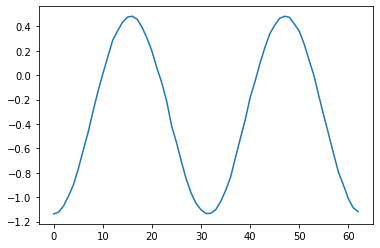

In [88]:
### full angle scan
import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))

In [ ]:
Hamilt.molcule.fci